In [54]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint
import scipy.linalg as la
from numpy import matmul as matmul
from numpy.linalg import inv as inv

from scipy.integrate import odeint

from pprint import pprint

In [55]:
### set up the constant portions, it seems as if the project is better understood as apply the control scheme to two
##different linearly decoupled portions of the airplane

# Part 1 Design RSLQR for first part of dynamics

In [56]:
##define the system and control matrices

A_sys1 = np.array([[-0.038, 18.984, 0, -32.174], [-0.001, -0.632, 1.0, 0], [0, -0.759, -0.518, 0], [0, 0, 1, 0]])
print("A_sys1 is\n", A_sys1)

B_cont1 = np.array([[0, 10.1], [-0.0086, 0], [-0.011, 0.025], [0, 0]])
print("B matrix is\n", B_cont1)

A_sys1 is
 [[-3.8000e-02  1.8984e+01  0.0000e+00 -3.2174e+01]
 [-1.0000e-03 -6.3200e-01  1.0000e+00  0.0000e+00]
 [ 0.0000e+00 -7.5900e-01 -5.1800e-01  0.0000e+00]
 [ 0.0000e+00  0.0000e+00  1.0000e+00  0.0000e+00]]
B matrix is
 [[ 0.00e+00  1.01e+01]
 [-8.60e-03  0.00e+00]
 [-1.10e-02  2.50e-02]
 [ 0.00e+00  0.00e+00]]


this is of course just the regular system, need to define the augmented system

In [57]:
### set up the augmented matrices
A_tilde1 = np.zeros((6,6))
A_tilde1[2:6,2:6] = A_sys1
A_tilde1[0:2, 2:4] = np.identity(2)
print("A_tilde is\n", A_tilde1)

B_tilde1 = np.zeros((6,2))
B_tilde1[2:6, 0:2] = B_cont1
print("B tilde1 is\n", B_tilde1)

A_tilde is
 [[ 0.0000e+00  0.0000e+00  1.0000e+00  0.0000e+00  0.0000e+00  0.0000e+00]
 [ 0.0000e+00  0.0000e+00  0.0000e+00  1.0000e+00  0.0000e+00  0.0000e+00]
 [ 0.0000e+00  0.0000e+00 -3.8000e-02  1.8984e+01  0.0000e+00 -3.2174e+01]
 [ 0.0000e+00  0.0000e+00 -1.0000e-03 -6.3200e-01  1.0000e+00  0.0000e+00]
 [ 0.0000e+00  0.0000e+00  0.0000e+00 -7.5900e-01 -5.1800e-01  0.0000e+00]
 [ 0.0000e+00  0.0000e+00  0.0000e+00  0.0000e+00  1.0000e+00  0.0000e+00]]
B tilde1 is
 [[ 0.00e+00  0.00e+00]
 [ 0.00e+00  0.00e+00]
 [ 0.00e+00  1.01e+01]
 [-8.60e-03  0.00e+00]
 [-1.10e-02  2.50e-02]
 [ 0.00e+00  0.00e+00]]


the next step is to design the controller parameters, since we need positive definiteness, start with identity

In [77]:
## we will set up the cost matrices and the target values, as well as the initializations
#the cost matrices


R1 = np.array([[100, -30], [-30,100]], dtype = float)
print("R is: \n", R1)
Q1 = np.identity(6)

r_u = 80
r_alpha = 0.1
r_vec1 = np.array([r_u, r_alpha, 0, 0, 0, 0])
r_vec1 = r_vec1.reshape((6,1))
print("error vec is:\n", r_vec1)

R is: 
 [[100. -30.]
 [-30. 100.]]
error vec is:
 [[80. ]
 [ 0.1]
 [ 0. ]
 [ 0. ]
 [ 0. ]
 [ 0. ]]


In [78]:
### set up the initializations as well, I am going to go with a velocity but none of the angles

z_init1 = np.array([0, 0, 38, 0.2, 0, 0], dtype=float)


print(z_init1)

[ 0.   0.  38.   0.2  0.   0. ]


In [79]:
###The solution to the algebraic riccati equation, to use continuously for the LQR portion
####this and the augmented matrices represent the RSLQR System
###for some reason, B and R must have same number of columns, but R must be invertible, which is confusing
#figured it out, R must be built from B, an explicit explanation of these matrix dimensions would have been nice

P1 = la.solve_continuous_are(a=A_tilde1, b=B_tilde1, q=Q1, r=R1)
print("P is:\n", P1)
K1 = matmul(inv(R1), matmul(B_tilde1.T, P1))
print("K is: \n", K1)

P is:
 [[ 1.86026042e+01  2.26075069e+01  3.22548450e+01  1.55693909e+04
  -1.30538218e+04 -2.29204632e+04]
 [ 2.26075069e+01  7.58164368e+02  3.99888249e+01  2.08899223e+04
  -1.65548312e+04 -3.02109740e+04]
 [ 3.22548450e+01  3.99888249e+01  5.95622193e+01  2.88382960e+04
  -2.41835390e+04 -4.24613175e+04]
 [ 1.55693909e+04  2.08899223e+04  2.88382960e+04  1.43289439e+07
  -1.20181675e+07 -2.10927345e+07]
 [-1.30538218e+04 -1.65548312e+04 -2.41835390e+04 -1.20181675e+07
   1.00813933e+07  1.76918990e+07]
 [-2.29204632e+04 -3.02109740e+04 -4.24613175e+04 -2.10927345e+07
   1.76918990e+07  3.10498544e+07]]
K is: 
 [[ 1.04657085e-01 -5.99211932e-03  1.87984235e-01  6.82934663e+01
  -5.71951615e+01 -1.00900246e+02]
 [ 2.56810081e-02 -1.01634132e-01  2.62946732e-02 -7.13859281e+01
   6.06523464e+01  1.04111608e+02]]


In [80]:
def Dyn_time_step1(z_vec, del_t, A, B, K, P, r_vec):
    """this function returns one time step in the dynamic equation for the RSLQR"""
    z_vec = z_vec.reshape((6,1))
    
    z_dot = matmul(A-matmul(B, K),z_vec) - r_vec
    
    z_dot = z_dot.reshape(6)
  
    return z_dot;

In [81]:
Dyn_time_step1(z_init1, 0.1, A_tilde1, B_tilde1, K1, P1, r_vec1)

array([-4.20000000e+01,  1.00000000e-01,  1.36460479e+02,  1.44980101e-02,
        4.08972737e-01,  0.00000000e+00])

# Part 2 Design RSLQR Controller for second dynamics

I am taking phi to be the roll angle

In [82]:
##define the system and control matrices

A_sys2 = np.array([[-0.0829, 0, -1, 0.0487], [-4.546, -1.699, 0.717, 0], [3.382, -0.0654, -0.0893, 0], [0, 1, 0, 0]])
print("A_sys1 is\n", A_sys1)

B_cont2 = np.array([[0, 0.0116], [27.276, 0.5758], [0.3952, -1.362], [0, 0]])
print("B matrix is\n", B_cont1)

A_sys1 is
 [[-3.8000e-02  1.8984e+01  0.0000e+00 -3.2174e+01]
 [-1.0000e-03 -6.3200e-01  1.0000e+00  0.0000e+00]
 [ 0.0000e+00 -7.5900e-01 -5.1800e-01  0.0000e+00]
 [ 0.0000e+00  0.0000e+00  1.0000e+00  0.0000e+00]]
B matrix is
 [[ 0.00e+00  1.01e+01]
 [-8.60e-03  0.00e+00]
 [-1.10e-02  2.50e-02]
 [ 0.00e+00  0.00e+00]]


In [83]:
### set up the augmented matrices
A_tilde2 = np.zeros((5,5))
A_tilde2[1:5,1:5] = A_sys2
A_tilde2[0,4] = 1
print("A_tilde is\n", A_tilde2)

B_tilde2 = np.zeros((5,2))
B_tilde2[1:5, 0:2] = B_cont2
print("B tilde2 is\n", B_tilde2)

A_tilde is
 [[ 0.      0.      0.      0.      1.    ]
 [ 0.     -0.0829  0.     -1.      0.0487]
 [ 0.     -4.546  -1.699   0.717   0.    ]
 [ 0.      3.382  -0.0654 -0.0893  0.    ]
 [ 0.      0.      1.      0.      0.    ]]
B tilde2 is
 [[ 0.0000e+00  0.0000e+00]
 [ 0.0000e+00  1.1600e-02]
 [ 2.7276e+01  5.7580e-01]
 [ 3.9520e-01 -1.3620e+00]
 [ 0.0000e+00  0.0000e+00]]


In [84]:
## we will set up the cost matrices and the target values, as well as the initializations
#the cost matrices


R2 = np.array([[100, -30], [-30,100]], dtype = float)
print("R is: \n", R2)
Q2 = np.identity(5)

r_phi = 0.2

r_vec2 = np.array([r_phi, 0, 0, 0, 0])
r_vec2 = r_vec2.reshape((5,1))
print("error vec is:\n", r_vec2)

R is: 
 [[100. -30.]
 [-30. 100.]]
error vec is:
 [[0.2]
 [0. ]
 [0. ]
 [0. ]
 [0. ]]


In [85]:
### set up the initializations as well, I am going to go with close to target

z_init2 = np.array([0, 0.15, 0, 0, 0], dtype=float)


print(z_init2)

[0.   0.15 0.   0.   0.  ]


In [86]:
###The solution to the algebraic riccati equation, to use continuously for the LQR portion
####this and the augmented matrices represent the RSLQR System
###for some reason, B and R must have same number of columns, but R must be invertible, which is confusing
#figured it out, R must be built from B, an explicit explanation of these matrix dimensions would have been nice

P2 = la.solve_continuous_are(a=A_tilde2, b=B_tilde2, q=Q2, r=R2)
print("P is:\n", P2)
K2 = matmul(inv(R2), matmul(B_tilde2.T, P2))
print("K is: \n", K2)

P is:
 [[ 2.0966969  -0.11781052  0.34763797  0.24318022  1.68518775]
 [-0.11781052 14.7377501  -0.26188596 -0.05585517  0.02353242]
 [ 0.34763797 -0.26188596  0.37501479  0.11944741  0.72688783]
 [ 0.24318022 -0.05585517  0.11944741  4.49459013  0.33769532]
 [ 1.68518775  0.02353242  0.72688783  0.33769532  3.17804559]]
K is: 
 [[ 0.10481929 -0.07842202  0.1130898   0.03536548  0.21920562]
 [ 0.03012171 -0.02256422  0.03442902 -0.04992537  0.06535043]]


In [87]:
def Dyn_time_step2(z_vec, del_t, A, B, K, P, r_vec):
    """this function returns one time step in the dynamic equation for the RSLQR for the second system"""
    z_vec = z_vec.reshape((5,1))
    
    z_dot = matmul(A-matmul(B, K),z_vec) - r_vec
    
    z_dot = z_dot.reshape(5)
  
    return z_dot;

In [88]:
Dyn_time_step2(z_init2, 0.1, A_tilde2, B_tilde2, K2, P2, r_vec2)

array([-0.2       , -0.01239574, -0.35909527,  0.50733899,  0.        ])

# Part 3 Simulate the Decoupled Dynamics

In [89]:
t = np.linspace(0, 800, 80000)
print(z_init1.shape)
z_sim1 = odeint(Dyn_time_step1, z_init1, t, (A_tilde1, B_tilde1, K1, P1, r_vec1))

(6,)


In [90]:
z_sim1.shape

(80000, 6)

In [91]:
u = z_sim1[:,2]
print(u.shape)
alpha = z_sim1[:,3]
print(alpha.shape)

(80000,)
(80000,)


Text(0, 0.5, 'airspeed(m/s)')

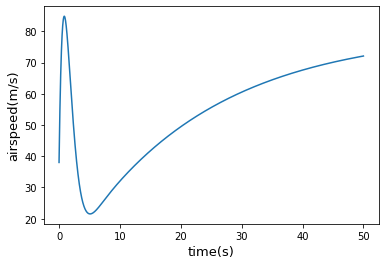

In [92]:
plt.plot(t[0:5000], u[0:5000])
#plt.plot(t,e_alpha)
plt.xlabel("time(s)",fontsize='13')
plt.ylabel("airspeed(m/s)",fontsize='13')

The input command for the plane is 40m/s, so we can see that we have convergence in that respect, the variation in the integral error is ##extremely## subject to intial conditions, I have restricted the length to show the convergence compared to the angle convergence

Text(0, 0.5, 'attack angle(rad)')

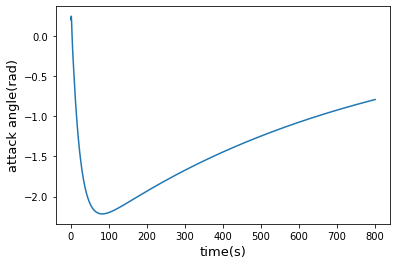

In [93]:
#plt.plot(t, e_u)
plt.plot(t,alpha)
plt.xlabel("time(s)",fontsize='13')
plt.ylabel("attack angle(rad)",fontsize='13')

The target value for the angle of attack is 0.25 radians, as best I can tell, the controller has a very hard time converging
on this value, my guess is that as I extend out the simulation the convergence becomes more likely. Form this I gather that the airplane controllers need to be very very carefully tuned to work properly. 

In [51]:
t = np.linspace(0, 150, 15000)
print(z_init2.shape)
z_sim2 = odeint(Dyn_time_step2, z_init2, t, (A_tilde2, B_tilde2, K2, P2, r_vec2))

(5,)


In [52]:
phi = z_sim2[:,4]
print(phi.shape)


(15000,)


Text(0, 0.5, 'phi(rad)')

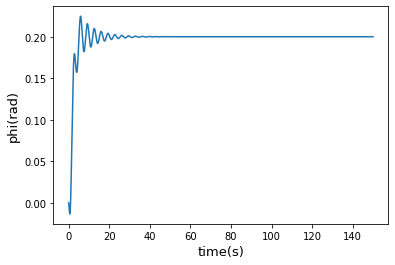

In [53]:
plt.plot(t, phi)
plt.xlabel("time(s)",fontsize='13')
plt.ylabel("phi(rad)",fontsize='13')

I actually assigned the wrong IC for this but it seems that phi is very convergent and very quickly, as the target value was
actually 0.2, but there is an interestingly large amount of vibration. This is probably due to the fact that there were
effectively two actuators pushing towards a single value, rather than two for two values as in the previous one